# Freckle Data Engineer Challenge
*22 Oct 2017  
Farooq Qaiser* 

## Admin  

initialize PySpark

In [2]:
import findspark

findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Freckle_challenge") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Load some of the basic libraries (we'll load others as we need them). 

In [5]:
from pyspark.sql import functions as func

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Set some display options. 

In [6]:
# show plots inline
%matplotlib inline

Set some parameters.  

In [12]:
seed = 1

input_path = "/home/fqaiser94/Data Engineer Challenge/location-data-sample/*.gz"

Read in data as dataframe

In [31]:
df = spark.read.json(input_path)

## RDD vs Dataframe

**RE: The expectation for this exercise is that you use Spark 2.x with Scala, Python, or Java. You can use the RDD or Dataframe APIs as you see fit, but please be ready to explain your choices.**  


I chose to use the Dataframe API over RDD API because:  
1. Dataframe API is able to take advantage of Spark’s Catalyst optimizer by exposing expressions and data fields to a query planner.
2. Dataframe API has speed advantage in most cases (see [here](http://www.adsquare.com/comparing-performance-of-spark-dataframes-api-to-spark-rdd/)). 
3. I find Dataframes an easier construction to work with  

There is obviously also the new Dataset API, which I know little about but apparently it combines the best of both worlds ...

## EDA

Always helpful to do some EDA to understand our data before diving in.  
Lets take a look at the dataframes schema.  

In [17]:
df.printSchema()

root
 |-- action: string (nullable = true)
 |-- api_key: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- beacon_major: long (nullable = true)
 |-- beacon_minor: long (nullable = true)
 |-- beacon_uuid: string (nullable = true)
 |-- city: string (nullable = true)
 |-- code: string (nullable = true)
 |-- community: string (nullable = true)
 |-- community_code: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- county: string (nullable = true)
 |-- county_code: string (nullable = true)
 |-- event_time: long (nullable = true)
 |-- geohash: string (nullable = true)
 |-- horizontal_accuracy: double (nullable = true)
 |-- idfa: string (nullable = true)
 |-- idfa_hash_alg: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- place: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- user_ip: string (nullable =

Humm that's a lot of columns, let's take a peek at our data. 

In [20]:
# show all columns
pd.set_option('display.max_columns', None)

In [21]:
df.limit(5).toPandas()

,action,api_key,app_id,beacon_major,beacon_minor,beacon_uuid,city,code,community,community_code,country_code,county,county_code,event_time,geohash,horizontal_accuracy,idfa,idfa_hash_alg,lat,lng,place,platform,state,state_code,user_ip
0,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Littleton,80123,,,US,Jefferson,059,1491066280,9xj32w4r1z1m,0.0,c50ab245-d660-435e-a226-8d311d2aebbf,,39.628926,-105.092048,Littleton,android,Colorado,CO,184.96.241.157
1,virtual_beacon_list_request,9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb,com.airkast.kbxxfm,0,0,,Houston,77067,,,US,Harris,201,1491066280,9vk47vts9tx0,9.0,8c14186b-070d-4933-a28f-a64e97afbb96,,29.957772,-95.452578,Houston,android,Texas,TX,45.18.76.214
2,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Groton,01450,,,US,Middlesex,017,1491066280,drt4k62nrypf,0.0,1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0,,42.596473,-71.531639,Groton,android,Massachusetts,MA,174.192.25.246
3,listrequest,e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0,com.checkout51.rc,0,0,,Media,19063,,,US,Delaware,045,1491066280,dr475f915hgy,0.0,9350ce13-d0a3-422b-a047-0f534d69c217,,39.916275,-75.419635,Media,ios,Pennsylvania,PA,107.77.204.113
4,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,0,0,,Paw Paw,49079,,,US,Van Buren,159,1491066280,dp6zvrr3u6wk,0.0,a6e440f4-695b-42b2-a149-b6da243d7ea5,,42.183695,-85.891952,Paw Paw,android,Michigan,MI,50.107.82.231


Looking at this output, each row/record shows where a user/IDFA was located and at what time. Looks like the information is being generated by apps on a user's phone.  

How many records do we have? 

In [38]:
(df
 .count()
)

8754673

How many countries does this data cover? 

In [22]:
(df
 .select('country_code')
 .distinct()
 .show()
)

+------------+
|country_code|
+------------+
|          LT|
|          DZ|
|          FI|
|          PM|
|          RO|
|          NL|
|          PL|
|          RE|
|          MK|
|          MX|
|          GL|
|          SM|
|          AT|
|          RU|
|          HR|
|          LI|
|          CZ|
|          VA|
|          PT|
|          BD|
+------------+
only showing top 20 rows



In [23]:
(df
 .select('country_code')
 .distinct()
 .count()
)

69

humm that's a lot of countries ... i imagine some are more important than others ...

In [24]:
(df
#  .select('country_code')
#  .distinct()
 .groupby('country_code')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show()
)

+------------+-------+
|country_code|records|
+------------+-------+
|          US|6715156|
|          CA|1921178|
|          JP|  21594|
|          GU|  13946|
|          MX|  12011|
|          GB|   8618|
|          BR|   5658|
|          TR|   5634|
|          DE|   4259|
|          AU|   4217|
|          PK|   3687|
|          NL|   3093|
|          PH|   2904|
|          PR|   2794|
|          BE|   2619|
|          CO|   2421|
|          RU|   2378|
|          ES|   2106|
|          FR|   1768|
|          TH|   1763|
+------------+-------+
only showing top 20 rows



Not surprising, dataset is focused on USA and Canada.     
I like visualizing stuff so let's do a map of user activity.  

In [ ]:
#map

What time period does this data cover? Guessing a lot since its 50GB uncompressed ...

In [32]:
# fix format of event_time column
df = (df
      .withColumn("event_time", func.from_unixtime("event_time"))
     )

In [33]:
(df
 .agg(func.min('event_time').alias('min_time'),
      func.max('event_time').alias('max_time'),
     )
 .toPandas()
)

,min_time,max_time
0,2017-03-31 19:57:38,2017-04-01 20:01:36


oh wow, this dataset has only one day's worth of activity ... and yet its 50GB on disk uncompressed ... nice.      

Alright, let's see what the action column is all about next.   

In [34]:
(df
 .groupby('action')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .toPandas()
)

,action,records
0,listrequest,2505370
1,virtual_beacon_list_request,2325582
2,config,1833233
3,enter,1140386
4,exit,773177
5,beacon_list_request,168145
6,visit,7356
7,near,1409
8,,15


I can guess what *enter*, *exit*, *visit*, and *near* refer to ... the rest I don't know ... virtual_beacon_list_request, must ask more about that in interview ... anyway this information seems irrelevant to the questions I've been asked to answer so no biggie.    

Not that this is relevant either but I'm curious to know what some of the biggest apps are that are contributing to this activity.    

In [36]:
(df
 .groupby('app_id')
 .agg(func.count('*').alias('records'))
 .orderBy('records', ascending=False)
 .show(truncate=False)
)

+----------------------------------------+-------+
|app_id                                  |records|
+----------------------------------------+-------+
|smartphones.collegescoreboard.football  |2209154|
|ca.indigo                               |915553 |
|ca.indigo.mobile                        |650734 |
|com.c51                                 |451973 |
|com.airkast.foxfm                       |360640 |
|com.airkast.mark_levin                  |307751 |
|com.airkast.tjms                        |306903 |
|smartphones.collegescoreboard.basketball|199874 |
|com.airkast.wfunfm                      |150798 |
|com.poynt.android                       |123729 |
|com.theweathernetwork.weathereyeiphone  |103781 |
|com.airkast.rsmsfm                      |82547  |
|com.lifelikeapps.classifieds            |78858  |
|com.jacapps.wbns                        |73427  |
|com.airkast.kmjqfm                      |64750  |
|com.mcdonalds.superapp                  |63037  |
|com.multiplied.poynt          

The usual candidates ... radio stations, sports apps and weather apps ... the kinds of apps that most users would have and open on their on phone ... I wonder if the data is being generated only when a user is using a given app or if the data is being generated even when the app is closed or working in the background.

Last but not least, let's just check how much missing data there is in the dataset.   

How much missing data? 

In [88]:
# https://stackoverflow.com/a/33308193

def blank_as_null(x):
    
    return (func.when(func.col(x) != "", func.col(x))
            .otherwise(None))

In [89]:
# columns to convert
to_convert = set(df.schema.names)

In [90]:
exprs = [
    blank_as_null(x).alias(x) if x in to_convert else x for x in df.columns]

df = (df.select(*exprs))

In [91]:
import missingno as msno

In [92]:
temp = (df
        # sample rows randomly
        .sample(False, 0.01, seed)
        .toPandas()
       )

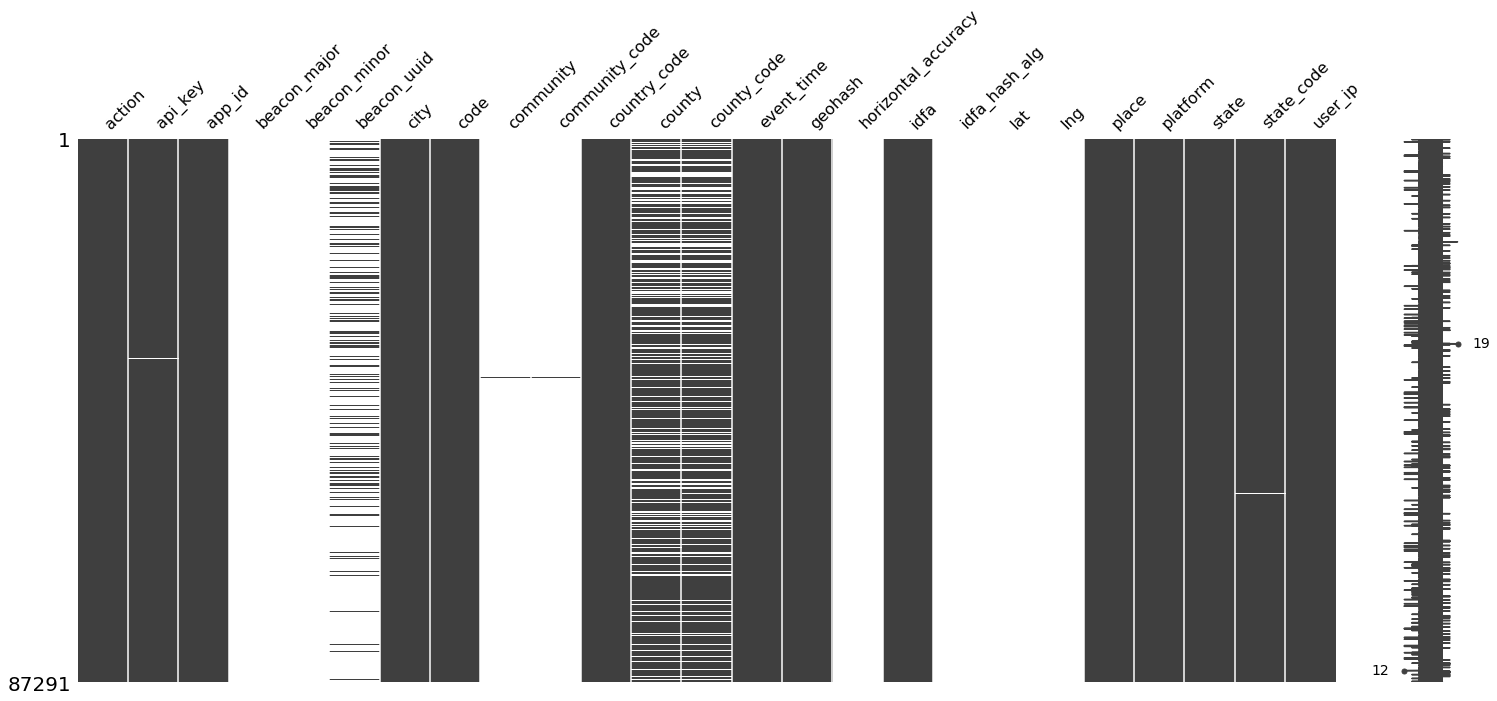

In [93]:
msno.matrix(temp, freq=False)

plt.show()

The missing data situation isn't too bad, seems to affect specific columns only. 

In [95]:
df.limit(5).toPandas()

,action,api_key,app_id,beacon_major,beacon_minor,beacon_uuid,city,code,community,community_code,country_code,county,county_code,event_time,geohash,horizontal_accuracy,idfa,idfa_hash_alg,lat,lng,place,platform,state,state_code,user_ip
0,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,None,None,None,Littleton,80123,None,None,US,Jefferson,059,2017-04-01 13:04:40,9xj32w4r1z1m,None,c50ab245-d660-435e-a226-8d311d2aebbf,None,None,None,Littleton,android,Colorado,CO,184.96.241.157
1,virtual_beacon_list_request,9de1430e73cc96f15272a8a081d127746d3d4ef3d123b6adb,com.airkast.kbxxfm,None,None,None,Houston,77067,None,None,US,Harris,201,2017-04-01 13:04:40,9vk47vts9tx0,None,8c14186b-070d-4933-a28f-a64e97afbb96,None,None,None,Houston,android,Texas,TX,45.18.76.214
2,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,None,None,None,Groton,01450,None,None,US,Middlesex,017,2017-04-01 13:04:40,drt4k62nrypf,None,1ed5c7d3-6b7b-4cbe-a726-7429eb1828c0,None,None,None,Groton,android,Massachusetts,MA,174.192.25.246
3,listrequest,e9d18b6c1b97cd776b1cd0c034a46738493151dc8e512acf0,com.checkout51.rc,None,None,None,Media,19063,None,None,US,Delaware,045,2017-04-01 13:04:40,dr475f915hgy,None,9350ce13-d0a3-422b-a047-0f534d69c217,None,None,None,Media,ios,Pennsylvania,PA,107.77.204.113
4,listrequest,9c4523f4cde116f32bf370656b35129cd9ced93c6ce6c1246,smartphones.collegescoreboard.football,None,None,None,Paw Paw,49079,None,None,US,Van Buren,159,2017-04-01 13:04:40,dp6zvrr3u6wk,None,a6e440f4-695b-42b2-a149-b6da243d7ea5,None,None,None,Paw Paw,android,Michigan,MI,50.107.82.231
